**Updated**: 08.08.2021

In [1]:
import numpy as np
import sqlite3 as sq
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from collections import Counter
import pyasn
import requests
from mpl_toolkits.basemap import Basemap
import time
import json

from colors import Colors

%matplotlib inline

In [2]:
connection = sq.connect("./performance-measurements/merged.db")
connection.row_factory = sq.Row
asndb = pyasn.pyasn('09-06-2021.dat')

In [3]:
vantage_points = {
                  'US East':                  {'short': 'us-east_', 'location': {'lat':  39.0437, 'lng': -77.4875}},
                  'Asia Pacific Northeast':   {'short': 'ap-northeast_', 'location': {'lat': 34.6937, 'lng': 135.5022}},
                  'Africa South':             {'short': 'af-south_', 'location': {'lat':  -33.9258, 'lng': 18.4232}},
                  'Europe Central':           {'short': 'eu-central_', 'location': {'lat': 50.1155, 'lng': 8.6842}},
                  'Asia Pacific Southeast':   {'short': 'ap-southeast_', 'location': {'lat': -33.8679, 'lng': 151.2073}},
                  'US West':                  {'short': 'us-west_', 'location': {'lat':  37.7749, 'lng': -122.4194}},
                  'South America East':       {'short': 'sa-east_', 'location': {'lat': -23.5475, 'lng': -46.6361}},
                  'All':                      {'short': '', 'location': {'lat': 0.0, 'lng': 0.0}}
                 }

In [3]:
def getRCodeCountForProtocol(protocol):
    df = pd.read_sql_query("SELECT r_code FROM dns_measurements WHERE r_code IS NOT NULL AND NOT cache_warming AND protocol = '{}'".format(protocol), connection)
    return df.groupby("r_code", as_index = True).size().reset_index(name = "count").set_index("r_code")

def getErrorSuccessCountForProtocol(protocol):
    df = pd.read_sql_query("SELECT r_code FROM dns_measurements WHERE created < 1624485600 AND protocol = '{}' AND NOT cache_warming AND ip IN (SELECT ip FROM dns_measurements WHERE protocol = '{}' AND r_code IS NOT NULL)".format(protocol, protocol), connection)
    success = (len(df.index) - df.isna().sum(axis = 0)).item()
    error = df.isna().sum(axis = 0).item()
    state = pd.DataFrame({ "status": ["success", "error", "error_rate"], "count": [(len(df.index) - df.isna().sum(axis = 0)).item(), df.isna().sum(axis = 0).item(), error / len(df.index)] })
    state = state.set_index("status")
    return state

def getErrorSuccessCountForQUIC():
    df = pd.read_sql_query("SELECT r_code FROM dns_measurements WHERE created < 1624485600 AND protocol = 'quic' AND not cache_warming AND (ip, port) IN (SELECT ip, port FROM dns_measurements WHERE protocol = 'quic' AND r_code IS NOT NULL)", connection)
    state = pd.DataFrame({ "status": ["success", "error", "error_rate"], "count": [(len(df.index) - df.isna().sum(axis = 0)).item(), df.isna().sum(axis = 0).item(), df.isna().sum(axis = 0).item() / len(df.index)] })
    state = state.set_index("status")
    return state

def getHTTPVersion():
    df = pd.read_sql_query("SELECT http_version FROM dns_measurements WHERE r_code is NOT NULL AND NOT cache_warming AND protocol = 'https'", connection)
    return df.groupby("http_version").size().reset_index(name = "count").set_index("http_version")

def getTLSVersions(protocol):
    df = pd.read_sql_query("SELECT tls_version FROM dns_measurements WHERE r_code is NOT NULL AND NOT cache_warming AND protocol = '{}'".format(protocol), connection)
    return df.groupby("tls_version").size().reset_index(name = "count").set_index("tls_version")

def getDoQVersions():
    df = pd.read_sql_query("SELECT q_ui_c_negotiated_protocol AS quic_negotiated_protocol FROM dns_measurements WHERE r_code is NOT NULL AND NOT cache_warming AND protocol = 'quic'", connection)
    return df.groupby("quic_negotiated_protocol").size().reset_index(name = "count").set_index("quic_negotiated_protocol")

def getQUICVersions():
    df = pd.read_sql_query("SELECT q_ui_c_version AS quic_version FROM dns_measurements WHERE q_ui_c_version IS NOT NULL AND NOT cache_warming AND protocol = 'quic'", connection)
    grouped_df = df.groupby("quic_version", as_index = False).size()
    def toText(row):
        if row["quic_version"] == 4278190109:
            return "Draft 29"
        elif row["quic_version"] == 4278190112:
            return "Draft 32"
        elif row["quic_version"] == 4278190114:
            return "Draft 34"
        else:
            return "Unknown"
    
    grouped_df["version_name"] = grouped_df.apply(toText, axis = 1)
    return grouped_df.set_index("quic_version")

def getDoQPortServers():
    df = pd.read_sql_query("SELECT DISTINCT ip, port FROM dns_measurements WHERE r_code is NOT NULL AND NOT cache_warming AND protocol = 'quic'", connection)
    counter = {}
    for i, row in df.iterrows():
        if row["ip"] not in counter:
            counter[row["ip"]] = {}
        counter[row["ip"]][row["port"]] = True
    only784 = 0
    only8853 = 0
    both = 0
    for key, value in counter.items():
        if 784 in value and 8853 in value:
            both += 1
        elif 784 in value:
            only784 += 1
        elif 8853 in value:
            only8853 += 1
    return pd.DataFrame({ "Port": ["784", "8853", "both"], "Count": [only784, only8853, both] }).set_index("Port")

def getCountOfUsableMeasurementsForProtocol(protocol):
    df = pd.read_sql_query("SELECT COUNT(*) as count FROM dns_measurements WHERE protocol = '{}' AND NOT cache_warming AND ip IN (SELECT ip FROM dns_measurements WHERE protocol = '{}' AND r_code IS NOT NULL)".format(protocol, protocol), connection)
    return df["count"].values[0]

def getUsableMeasurements():
    count_udp = getCountOfUsableMeasurementsForProtocol("udp")
    return pd.DataFrame({ "Protocol": ["UDP", "TCP", "TLS", "HTTPS", "QUIC"], "Count": [
        getCountOfUsableMeasurementsForProtocol("udp"),
        getCountOfUsableMeasurementsForProtocol("tcp"),
        getCountOfUsableMeasurementsForProtocol("tls"),
        getCountOfUsableMeasurementsForProtocol("https"),
        getCountOfUsableMeasurementsForProtocol("quic")
    ] }).set_index("Protocol")

def categorizeErrors(errors):
    result = Counter()
    for _, row in errors.iterrows():
        if "i/o timeout" in row["error"]:
            result["timeout"] += 1
        elif "connection refused" in row["error"]:
            result["connection_refused"] += 1
        elif "no route to host" in row["error"]:
            result["no_route"] += 1
        elif "overflow unpacking uint16" in row["error"]:
            result["overflow"] += 1
        elif "EOF" in row["error"]:
            result["eof"] += 1
        elif "unrecognized name" in row["error"]:
            result["unrecognized_name"] += 1
        elif "request canceled" in row["error"]:
            result["request_canceled"] += 1
        elif "context deadline exceeded" in row["error"]:
            result["timeout"] += 1
        elif "tls: internal error" in row["error"]:
            result["tls_internal_error"] += 1
        elif "tls: handshake failure" in row["error"]:
            result["tls_handshake_failure"] += 1 
        elif "stopped after" in row["error"]:
            result["too_many_redirect"] += 1
        elif "bad rdata" in row["error"]:
            result["bad_rdata"] += 1
        elif "stream error" in row["error"]:
            result["stream_error"] += 1
        elif "connection reset by peer" in row["error"]:
            result["connection_reset"] += 1
        elif "server gave HTTP response to HTTPS client" in row["error"]:
            result["http_response"] += 1
        elif "network is unreachable" in row["error"]:
            result["network_unreachable"] += 1
        else:
            print(row["error"])
    return pd.DataFrame.from_dict(result, orient='index').reset_index().rename(columns={'index':'error', 0:'count'}).set_index("error")

def categorizeQUICErrors(errors):
    result = Counter()
    for _, row in errors.iterrows():
        if "No recent network activity" in row["error"]:
            result["timeout"] += 1
        elif "tls: internal error" in row["error"]:
            result["tls_internal_error"] += 1
        else:
            print(row["error"])
    return pd.DataFrame.from_dict(result, orient='index').reset_index().rename(columns={'index':'error', 0:'count'}).set_index("error")
        
def getTotalErrorsCategorized(protocol):
    udp_errors = pd.read_sql_query("SELECT error FROM dns_measurements WHERE protocol = '{}' AND NOT cache_warming AND error IS NOT NULL".format(protocol), connection)
    return categorizeErrors(udp_errors)

def getErrorsCategorized(protocol):
    udp_errors = pd.read_sql_query("SELECT error FROM dns_measurements WHERE created < 1624485600 AND protocol = '{}' AND NOT cache_warming AND error IS NOT NULL AND ip IN (SELECT ip FROM dns_measurements WHERE protocol = '{}' AND r_code IS NOT NULL)".format(protocol, protocol), connection)
    return categorizeErrors(udp_errors)

def getQUICTotalErrorsCategorized():
    udp_errors = pd.read_sql_query("SELECT error FROM dns_measurements WHERE protocol = 'quic' AND NOT cache_warming AND error IS NOT NULL AND r_code IS NULL", connection)
    return categorizeQUICErrors(udp_errors)

def getQUICErrorsCategorized():
    udp_errors = pd.read_sql_query("SELECT error FROM dns_measurements WHERE created < 1624485600 AND protocol = 'quic' AND error IS NOT NULL AND r_code IS NULL AND not cache_warming AND (ip, port) IN (SELECT ip, port FROM dns_measurements WHERE protocol = 'quic' AND r_code IS NOT NULL)", connection)
    return categorizeQUICErrors(udp_errors)

def getASN():
    def lookupAPI(row):
        r = requests.get("http://api.asrank.caida.org/v2/restful/asns/" + str(row["ASN"]))
        json = r.json()
        return json["data"]["asn"]["asnName"]
    df = pd.read_sql_query("SELECT DISTINCT ip FROM dns_measurements WHERE protocol = 'quic' AND r_code IS NOT NULL", connection)
    df["ASN"] = df.apply(lambda row: asndb.lookup(row["ip"])[0], axis = 1)
    grouped_df = df.groupby("ASN", as_index = False).size()
    largest = grouped_df.nlargest(10, "size")
    largest["ASN Name"] = largest.apply(lookupAPI, axis = 1)
    return largest

In [6]:
def quicIPs():
    sql = """
    SELECT DISTINCT ip FROM dns_measurements_clean WHERE protocol = 'quic'
    """
    cursor = connection.cursor()
    cursor.execute(sql)
    items = list(cursor.fetchall())
    cursor.close()
    return items

ips = quicIPs()

data = {}
try:
    df = pd.read_csv("ip-location.csv")
    for index, row in df.iterrows():
        data[row["ip"]] = row
except:
    pass
for row in ips:
    if row["ip"] in data:
        continue
    r = requests.get("http://ip-api.com/json/" + row["ip"])
    json = r.json()
    data[row["ip"]] = {
        "country": json["country"],
        "countryCode": json["countryCode"],
        "region": json["region"],
        "regionName": json["regionName"],
        "city": json["city"],
        "zip": json["zip"],
        "lat": json["lat"],
        "lon": json["lon"],
        "org": json["org"],
        "as": json["as"],
        "ip": row["ip"]
    }
    time.sleep(2)
df_all_doq = pd.DataFrame.from_dict(data, orient = "index")
df_all_doq.to_csv("ip-location.csv", index = False)

def drawAllDoQResolver():
    # set up orthographic map projection with
    # perspective of satellite looking down at 50N, 100W.
    # use low resolution coastlines.
    plt.figure(figsize=(12,6))
    worldMap = Basemap(projection='robin', lon_0=0, resolution='l')
    worldMap.drawcountries(color='#ffffff', linewidth=0.5)
    worldMap.fillcontinents(color='#c0c0c0', lake_color='#ffffff')
    x, y = worldMap(df_all_doq["lon"].tolist(), df_all_doq["lat"].tolist())
    homeX, homeY = worldMap([11.66864063068705], [48.26187023547006])
    plt.plot(x, y, 'bo', color = 'r', markersize = 3)
    plt.plot(homeX, homeY, 'bo', color = 'b', markersize = 5)
    plt.savefig("figures/all_doq_resolvers.pdf", bbox_inches='tight')
    plt.show()

In [10]:
def drawAllForProtocol(protocol, vp_key='All'):
    vp=vantage_points[vp_key]['short']
    df = pd.read_sql_query("SELECT * FROM dns_measurements_clean WHERE protocol = '{}' AND id LIKE '{}%' AND NOT cache_warming".format(protocol, vp), connection)
    grouped_df = df["ip"].unique()

    ips = df["ip"].unique()
    locations = []
    for ip in ips:
        if ip in data:
            locations.append({ "lon": data[ip]["lon"], "lat": data[ip]["lat"] })

    # set up orthographic map projection with
    # perspective of satellite looking down at 50N, 100W.
    # use low resolution coastlines.
    plt.figure(figsize=(12,6))
    worldMap = Basemap(projection='robin', lon_0=0, resolution='l')
    worldMap.drawcountries(color='#ffffff', linewidth=0.5)
    worldMap.fillcontinents(color='#c0c0c0', lake_color='#ffffff')
    x, y = worldMap(list(map(lambda x: x["lon"], locations)), list(map(lambda x: x["lat"], locations)))
    plt.plot(x, y, 'ro', markersize = 3)
    if vp_key != 'All':
        vp_loc = vantage_points[vp_key]['location']
        homeX, homeY = worldMap([vp_loc['lng']], [vp_loc['lat']])
        plt.plot(homeX, homeY, 'bo', markersize = 5)
    plt.savefig("figures/{}map_all_{}.pdf".format(vp, protocol), bbox_inches='tight')
    plt.show()
    
def drawSlowestForProtocol(protocol, vp_key='All'):
    vp=vantage_points[vp_key]['short']
    df = pd.read_sql_query("SELECT * FROM dns_measurements_clean WHERE protocol = '{}' AND id LIKE '{}%' AND NOT cache_warming".format(protocol, vp), connection)
    grouped_df = df.groupby("ip")
    mean_df = grouped_df["total_time"].mean()
    mean_df = mean_df.reset_index()
    largest = mean_df.nlargest(20, "total_time")

    ips = largest["ip"].tolist()
    print(f"IP addresses: {ips}")
    locations = []
    for ip in ips:
        if ip in data:
            locations.append({ "lon": data[ip]["lon"], "lat": data[ip]["lat"] })

    plt.figure(figsize=(12,6))
    worldMap = Basemap(projection='robin', lon_0=0, resolution='l')
    worldMap.drawcountries(color='#ffffff', linewidth=0.5)
    worldMap.fillcontinents(color='#c0c0c0', lake_color='#ffffff')
    x, y = worldMap(list(map(lambda x: x["lon"], locations)), list(map(lambda x: x["lat"], locations)))
    plt.plot(x, y, 'ro', markersize = 3)
    if vp_key != 'All':
        vp_loc = vantage_points[vp_key]['location']
        homeX, homeY = worldMap([vp_loc['lng']], [vp_loc['lat']])
        plt.plot(homeX, homeY, 'bo', markersize = 5)
    plt.savefig("figures/{}map_slowest_{}.pdf".format(vp, protocol), bbox_inches='tight')
    plt.show()
    
def drawFastestForProtocol(protocol, vp_key='All'):
    vp=vantage_points[vp_key]['short']
    df = pd.read_sql_query("SELECT * FROM dns_measurements_clean WHERE protocol = '{}' AND id LIKE '{}%' AND NOT cache_warming".format(protocol, vp), connection)
    grouped_df = df.groupby("ip")
    mean_df = grouped_df["total_time"].mean()
    mean_df = mean_df.reset_index()
    largest = mean_df.nsmallest(20, "total_time")

    ips = largest["ip"].tolist()
    print(f"IP addresses: {ips}")
    locations = []
    for ip in ips:
        if ip in data:
            locations.append({ "lon": data[ip]["lon"], "lat": data[ip]["lat"] })

    plt.figure(figsize=(12,6))
    worldMap = Basemap(projection='robin', lon_0=0, resolution='l')
    worldMap.drawcountries(color='#ffffff', linewidth=0.5)
    worldMap.fillcontinents(color='#c0c0c0', lake_color='#ffffff')
    x, y = worldMap(list(map(lambda x: x["lon"], locations)), list(map(lambda x: x["lat"], locations)))
    plt.plot(x, y, 'ro', markersize = 3)
    if vp_key != 'All':
        vp_loc = vantage_points[vp_key]['location']
        homeX, homeY = worldMap([vp_loc['lng']], [vp_loc['lat']])
        plt.plot(homeX, homeY, 'bo', markersize = 5)
    plt.savefig("figures/{}map_fastest_{}.pdf".format(vp, protocol), bbox_inches='tight')
    plt.show()

## General Data

In [13]:
df_general = pd.read_sql_query("SELECT COUNT(*) as total_measurements FROM dns_measurements WHERE NOT cache_warming", connection)
print(df_general.to_markdown())

|    |   total_measurements |
|---:|---------------------:|
|  0 |          1.14963e+06 |


#### Total Measurements per Protocol

In [14]:
measurements_per_protocol = pd.read_sql_query("SELECT protocol, COUNT(*) as count FROM dns_measurements WHERE NOT cache_warming GROUP BY protocol", connection)
print(measurements_per_protocol.set_index("protocol").to_markdown())

| protocol   |   count |
|:-----------|--------:|
| https      |  191495 |
| quic       |  381797 |
| tcp        |  192125 |
| tls        |  191825 |
| udp        |  192389 |


#### Usable Measurements per Protocol

- All the measurements of resolvers which have at least one successful response
- success = response with a r_code
- error = response without a r_code

In [15]:
print(getUsableMeasurements().to_markdown())

| Protocol   |   Count |
|:-----------|--------:|
| UDP        |   86066 |
| TCP        |   86786 |
| TLS        |  155300 |
| HTTPS      |   96408 |
| QUIC       |  379983 |


#### Total Number of Response Codes across Protocols

In [16]:
df_general = pd.read_sql_query("SELECT r_code FROM dns_measurements WHERE r_code IS NOT NULL AND NOT cache_warming", connection)
df_general = df_general.groupby("r_code", as_index = True).size().reset_index(name = "count").set_index("r_code")
print(df_general.to_markdown())

|   r_code |   count |
|---------:|--------:|
|        0 |  477326 |
|        2 |    2224 |
|        3 |    6891 |
|        5 |    8204 |


#### Number of Servers per Protocol

In [17]:
df = pd.read_sql_query("SELECT DISTINCT(ip), protocol FROM dns_measurements WHERE r_code IS NOT NULL AND NOT cache_warming", connection)
df = df.groupby("protocol").size().reset_index(name = "count").set_index("protocol")
print(df.to_markdown())

| protocol   |   count |
|:-----------|--------:|
| https      |     436 |
| quic       |     862 |
| tcp        |     391 |
| tls        |     701 |
| udp        |     389 |


<br>
<br>
<br>
<br>

## QUIC

In [18]:
print(getRCodeCountForProtocol("quic").to_markdown())

|   r_code |   count |
|---------:|--------:|
|        0 |  159500 |
|        2 |     791 |
|        3 |    1573 |
|        5 |    1331 |


In [178]:
print(getErrorSuccessCountForQUIC().to_markdown())

| status     |         count |
|:-----------|--------------:|
| success    | 23279         |
| error      |  1050         |
| error_rate |     0.0431584 |


#### All errors

In [20]:
print(getQUICTotalErrorsCategorized().to_markdown())

| error              |   count |
|:-------------------|--------:|
| timeout            |  218523 |
| tls_internal_error |      79 |


#### Errors for Successful Servers

In [21]:
print(getQUICErrorsCategorized().to_markdown())

| error   |   count |
|:--------|--------:|
| timeout |    1050 |


#### DoQ Versions

In [22]:
print(getDoQVersions().to_markdown())

| quic_negotiated_protocol   |   count |
|:---------------------------|--------:|
| doq-i00                    |   21335 |
| doq-i02                    |  141860 |


#### QUIC Versions

In [23]:
print(getQUICVersions().to_markdown())

|   quic_version |   size | version_name   |
|---------------:|-------:|:---------------|
|     4278190109 | 112302 | Draft 29       |
|     4278190112 |  12295 | Draft 32       |
|     4278190114 |  38599 | Draft 34       |


#### DOQ Ports

In [24]:
print(getDoQPortServers().to_markdown())

| Port   |   Count |
|:-------|--------:|
| 784    |     680 |
| 8853   |     169 |
| both   |      13 |


#### 0-RTT

No servers were found with support for QUIC 0-RTT

<br>
<br>
<br>
<br>

#### All DoQ Resolvers

In [ ]:
drawAllDoQResolver()

In [10]:
countriesContinents = pd.read_csv("Countries-Continents.csv", index_col = False)
renamed = countriesContinents.columns.tolist()
renamed[0] = "country"
countriesContinents.columns = renamed
byCountry = df_all_doq.groupby("country").size().reset_index(name = "size").sort_values("size", ascending = False)
withContinent = pd.merge(byCountry, countriesContinents, on = "country")
withContinent.groupby(["region"]).sum("size").reset_index()[["region", "size"]]

,region,size
0,Africa,7
1,Americas,202
2,Asia,419
3,Europe,253
4,Oceania,23


### Slowest QUIC Resolvers

US East
IP addresses: ['47.94.3.71', '168.138.198.116', '47.107.67.12', '49.233.84.156', '49.232.154.154', '175.27.159.83', '46.32.10.110', '123.60.43.85', '220.165.15.137', '42.193.131.158', '112.74.57.177', '42.192.5.73', '45.124.65.250', '103.161.164.164', '222.124.173.197', '92.223.109.31', '80.211.91.157', '39.65.180.224', '91.230.211.67', '122.6.181.55']


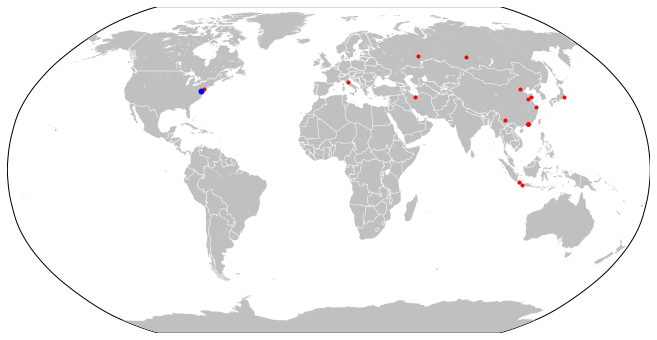

Asia Pacific Northeast
IP addresses: ['47.94.3.71', '168.138.198.116', '46.32.10.110', '49.232.154.154', '49.233.84.156', '47.107.67.12', '123.60.43.85', '175.27.159.83', '112.74.57.177', '42.193.131.158', '220.165.15.137', '42.192.5.73', '152.70.222.67', '200.25.62.68', '45.124.65.250', '80.211.91.157', '92.223.109.31', '222.124.173.197', '119.23.211.32', '45.224.113.199']


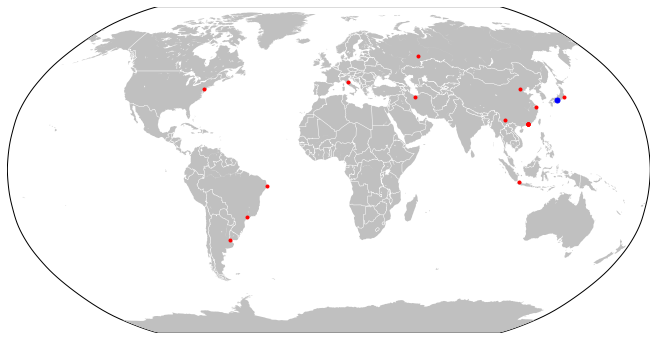

Africa South
IP addresses: ['47.94.3.71', '168.138.198.116', '45.124.65.250', '49.232.154.154', '47.107.67.12', '175.27.159.83', '49.233.84.156', '46.32.10.110', '123.60.43.85', '114.233.93.226', '42.193.131.158', '220.165.15.137', '112.74.57.177', '42.192.5.73', '222.124.173.197', '122.6.181.55', '182.134.132.31', '139.198.40.155', '92.223.109.31', '114.85.122.176']


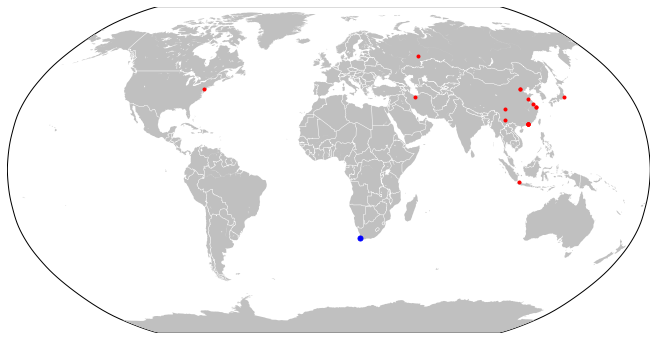

Europe Central
IP addresses: ['47.94.3.71', '168.138.198.116', '175.27.159.83', '47.107.67.12', '49.232.154.154', '49.233.84.156', '123.60.43.85', '46.32.10.110', '42.193.131.158', '220.165.15.137', '42.192.5.73', '112.74.57.177', '103.161.164.164', '101.35.92.96', '222.124.173.197', '101.35.113.194', '116.118.44.237', '14.237.203.241', '114.85.122.176', '122.112.202.153']


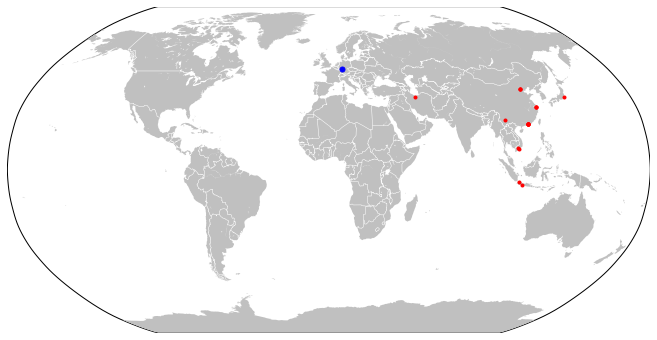

Asia Pacific Southeast
IP addresses: ['47.94.3.71', '168.138.198.116', '46.32.10.110', '49.233.84.156', '49.232.154.154', '175.27.159.83', '47.107.67.12', '123.60.43.85', '112.74.57.177', '42.193.131.158', '220.165.15.137', '42.192.5.73', '8.131.55.156', '45.124.65.250', '92.223.109.31', '39.65.180.224', '80.211.91.157', '197.242.149.195', '154.0.173.6', '47.105.64.215']


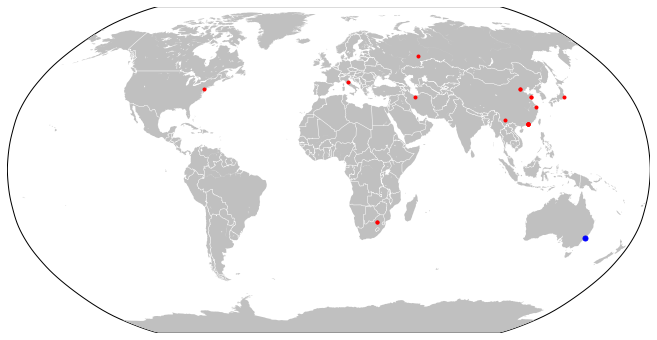

US West
IP addresses: ['47.94.3.71', '168.138.198.116', '49.233.84.156', '46.32.10.110', '49.232.154.154', '47.107.67.12', '175.27.159.83', '123.60.43.85', '220.165.15.137', '42.193.131.158', '112.74.57.177', '42.192.5.73', '222.124.173.197', '92.223.109.31', '80.211.91.157', '116.204.183.61', '91.230.211.67', '39.65.180.224', '176.102.36.61', '5.101.218.126']


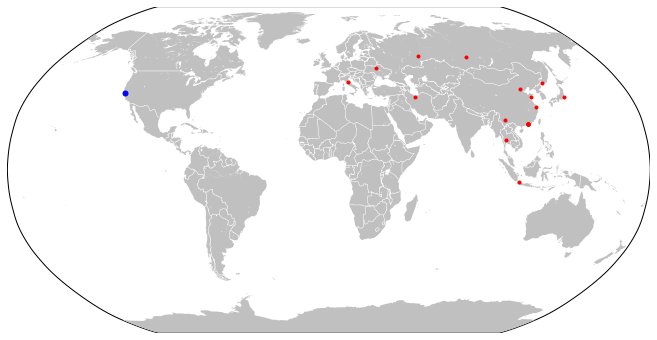

South America East
IP addresses: ['47.94.3.71', '168.138.198.116', '47.107.67.12', '49.233.84.156', '49.232.154.154', '46.32.10.110', '175.27.159.83', '123.60.43.85', '220.165.15.137', '42.193.131.158', '112.74.57.177', '42.192.5.73', '222.124.173.197', '45.124.65.250', '92.223.109.31', '116.204.183.61', '91.230.211.67', '202.83.122.170', '39.108.55.49', '39.65.180.224']


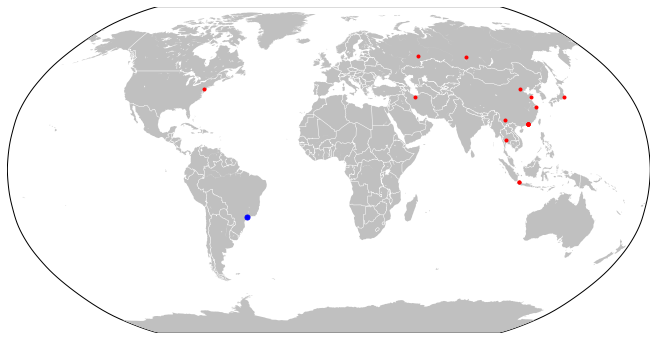

All
IP addresses: ['47.94.3.71', '168.138.198.116', '49.233.84.156', '49.232.154.154', '47.107.67.12', '46.32.10.110', '175.27.159.83', '123.60.43.85', '42.193.131.158', '220.165.15.137', '112.74.57.177', '42.192.5.73', '45.124.65.250', '103.161.164.164', '222.124.173.197', '92.223.109.31', '80.211.91.157', '39.65.180.224', '139.198.40.155', '116.204.183.61']


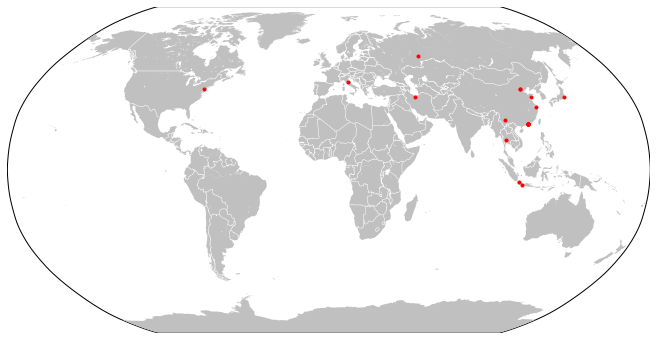

In [11]:
for key, vp in vantage_points.items():
    print(key)
    drawSlowestForProtocol("quic", key)

### Fastest QUIC Resolvers

US East
IP addresses: ['199.119.65.94', '170.39.224.134', '213.227.173.235', '34.205.57.244', '34.86.106.186', '150.136.110.156', '150.136.0.232', '51.81.81.178', '54.205.227.31', '147.182.175.157', '158.101.98.125', '132.145.199.27', '207.246.91.188', '162.220.223.23', '143.244.168.108', '104.225.216.16', '45.63.15.35', '8.9.5.237', '35.211.28.238', '74.118.141.85']


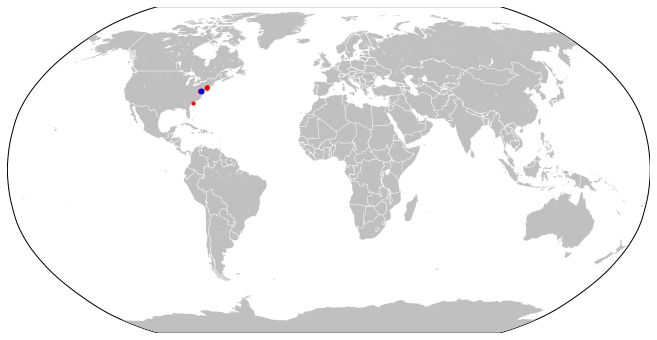

Asia Pacific Northeast
IP addresses: ['168.138.47.72', '202.218.2.19', '168.138.36.228', '152.70.86.5', '152.69.204.173', '168.138.55.10', '218.251.80.123', '203.76.245.200', '168.138.53.111', '45.78.53.214', '206.190.236.73', '192.243.125.8', '103.88.47.112', '13.113.218.223', '168.138.198.137', '202.182.110.254', '172.93.221.234', '158.101.69.250', '158.101.149.111', '43.128.232.106']


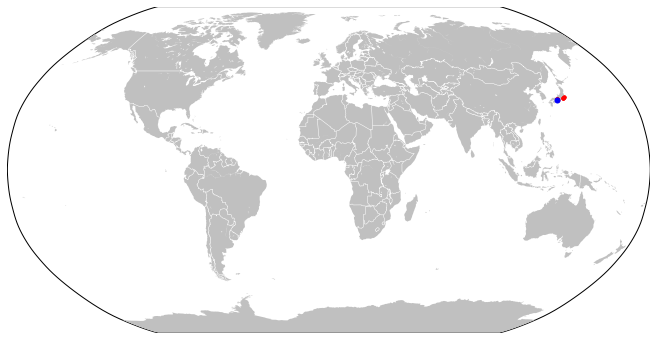

Africa South
IP addresses: ['188.172.217.27', '102.37.108.139', '41.21.230.0', '154.0.173.6', '197.242.149.195', '102.68.86.68', '45.155.39.173', '185.121.25.64', '18.135.203.88', '140.238.86.206', '132.226.130.157', '217.182.205.156', '54.37.166.116', '137.74.168.227', '87.98.165.2', '23.94.105.148', '132.145.58.214', '178.62.213.209', '5.189.204.17', '176.58.89.224']


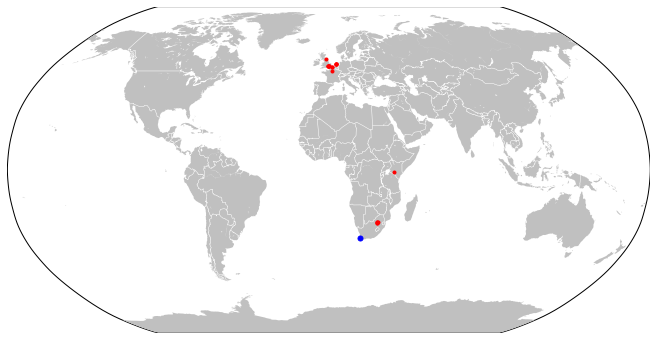

Europe Central
IP addresses: ['94.140.14.14', '94.140.14.140', '94.140.15.16', '94.140.14.15', '94.140.15.15', '94.140.14.141', '94.237.28.127', '194.156.162.9', '217.146.22.163', '34.141.58.85', '46.101.217.169', '159.89.108.152', '35.156.129.204', '130.61.15.226', '152.70.189.89', '139.162.142.149', '35.198.139.194', '130.61.75.201', '62.113.206.254', '130.61.127.15']


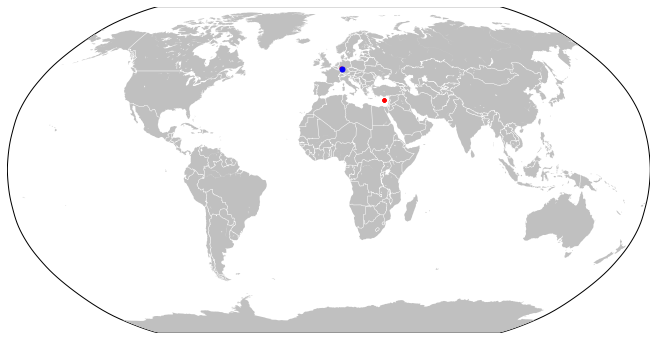

Asia Pacific Southeast
IP addresses: ['207.148.84.39', '103.212.225.153', '51.161.192.79', '51.161.192.78', '119.252.80.57', '139.99.239.191', '139.99.135.223', '152.67.100.3', '94.140.14.140', '94.140.14.15', '94.140.15.15', '94.140.14.141', '94.140.14.14', '94.140.15.16', '112.213.39.133', '45.121.209.148', '119.252.95.133', '103.62.50.101', '119.252.72.43', '119.252.93.133']


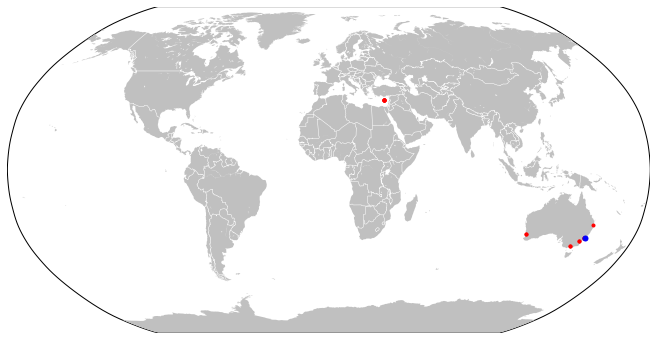

US West
IP addresses: ['173.255.246.78', '107.173.87.215', '143.110.229.87', '173.230.153.18', '137.184.118.216', '47.254.64.251', '45.61.53.161', '107.173.149.200', '94.140.15.15', '94.140.14.141', '94.140.14.140', '94.140.14.14', '94.140.14.15', '94.140.15.16', '202.5.18.122', '104.128.93.161', '172.86.125.249', '198.55.123.249', '45.88.195.157', '204.15.75.156']


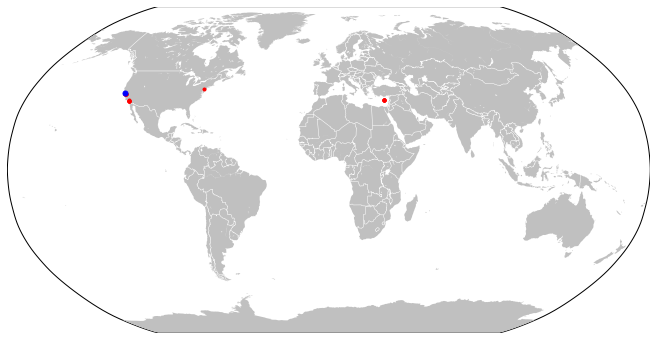

South America East
IP addresses: ['200.25.57.69', '45.11.105.129', '152.70.222.67', '191.252.186.173', '200.25.53.117', '37.252.239.39', '217.146.28.67', '200.25.62.68', '45.224.113.199', '200.25.36.70', '200.25.22.68', '37.252.251.157', '191.255.114.170', '147.182.175.157', '54.205.227.31', '158.101.98.125', '143.244.168.108', '51.81.81.178', '104.225.216.16', '200.25.45.97']


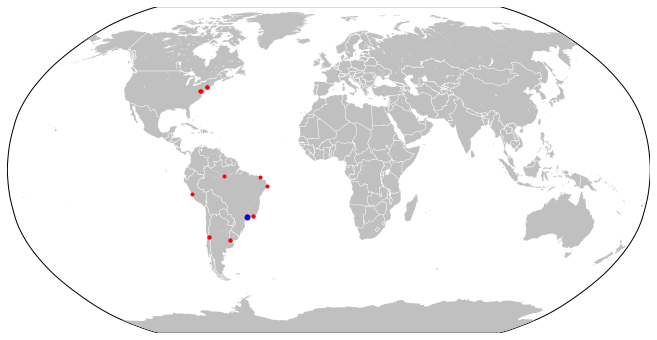

All
IP addresses: ['119.252.72.43', '94.140.14.140', '94.140.15.15', '94.140.14.15', '94.140.14.14', '94.140.14.141', '94.140.15.16', '193.123.247.107', '54.205.227.31', '147.182.175.157', '158.101.98.125', '104.225.216.16', '143.244.168.108', '83.50.6.24', '132.145.199.27', '45.88.195.246', '45.88.195.157', '34.121.75.184', '18.236.176.82', '204.15.75.156']


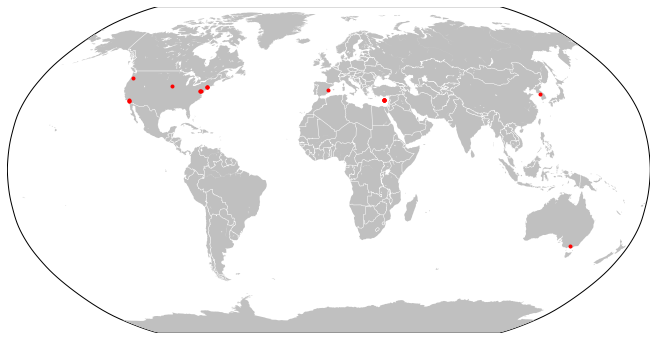

In [12]:
for key, vp in vantage_points.items():
    print(key)
    drawFastestForProtocol("quic", key)

### Slowest UDP Resolvers

US East
IP addresses: ['47.107.67.12', '202.83.122.170', '103.155.251.244', '58.8.84.129', '182.234.39.52', '159.117.87.167', '80.211.91.157', '103.124.95.99', '223.100.110.66', '103.172.17.226', '149.28.148.61', '103.138.41.195', '197.242.149.195', '110.188.20.184', '103.172.17.225', '103.136.18.163', '151.192.142.124', '103.27.62.211', '139.159.143.70', '47.106.251.191']


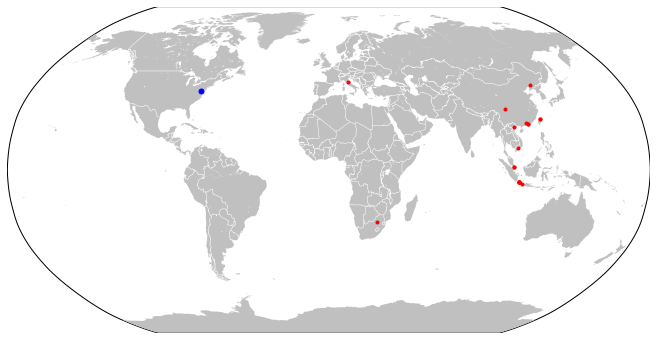

Asia Pacific Northeast
IP addresses: ['80.211.91.157', '197.242.149.195', '154.0.173.6', '41.21.230.0', '152.70.222.67', '102.37.108.139', '47.107.67.12', '198.46.152.146', '91.122.210.4', '188.82.243.76', '87.117.38.246', '78.15.98.77', '95.169.1.180', '194.87.236.82', '176.102.36.61', '198.55.120.204', '202.5.18.122', '144.34.176.166', '198.55.123.249', '204.44.70.240']


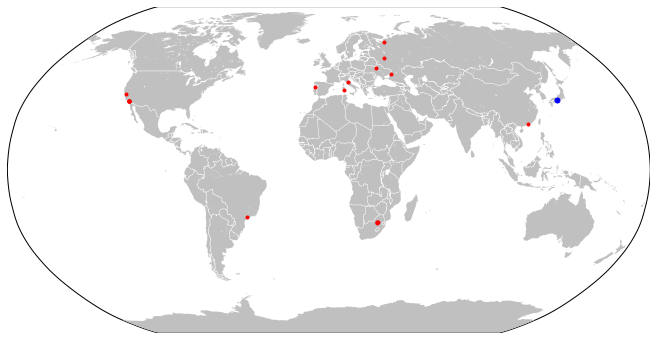

Africa South
IP addresses: ['47.107.67.12', '80.211.91.157', '141.168.36.153', '151.192.142.124', '121.133.94.94', '182.234.39.52', '114.32.120.125', '139.99.239.191', '116.33.230.28', '223.100.110.66', '146.56.106.110', '146.56.112.4', '152.67.216.48', '146.56.118.248', '114.34.162.81', '183.108.42.179', '183.100.236.26', '59.23.177.75', '121.170.60.153', '34.80.179.109']


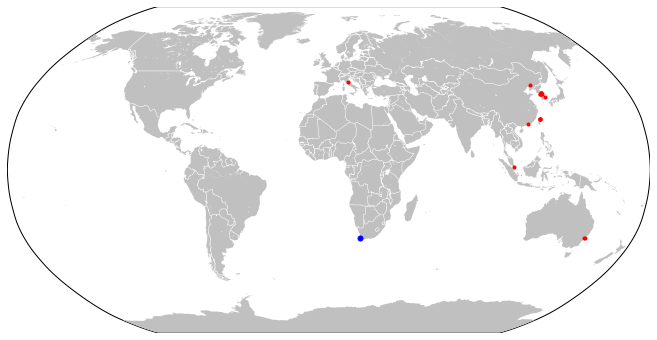

Europe Central
IP addresses: ['47.107.67.12', '140.238.10.79', '132.145.85.234', '141.168.36.153', '132.145.83.120', '193.122.127.79', '151.192.142.124', '121.133.94.94', '182.234.39.52', '59.23.177.75', '114.32.120.125', '139.99.239.191', '116.33.230.28', '58.8.84.129', '146.56.106.110', '146.56.118.248', '152.67.204.139', '146.56.112.4', '183.108.42.179', '121.170.60.153']


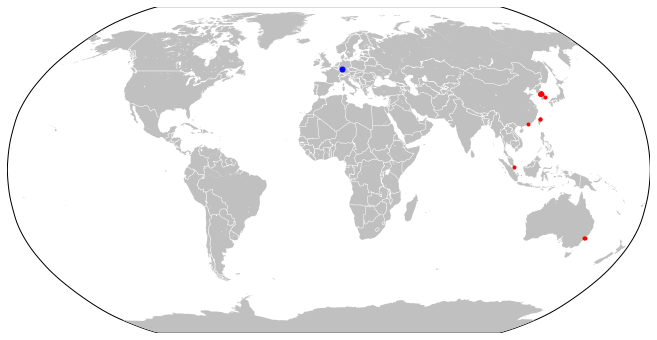

Asia Pacific Southeast
IP addresses: ['47.107.67.12', '197.242.149.195', '80.211.91.157', '154.0.173.6', '41.21.230.0', '102.37.108.139', '194.87.236.82', '130.193.38.204', '91.122.210.4', '47.105.64.215', '39.65.180.224', '82.118.227.235', '199.247.17.85', '176.102.36.61', '46.161.54.34', '152.70.222.67', '47.109.80.110', '188.82.243.76', '77.37.218.102', '195.140.152.244']


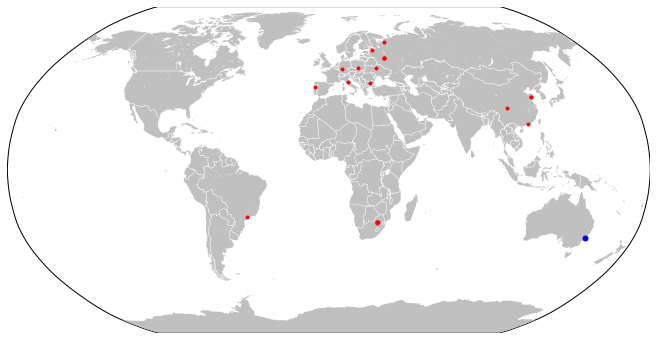

US West
IP addresses: ['47.107.67.12', '197.242.149.195', '154.0.173.6', '102.37.108.139', '41.21.230.0', '220.165.15.137', '103.155.251.244', '103.153.73.188', '185.177.218.107', '103.27.62.211', '194.5.79.82', '58.8.84.129', '152.67.9.211', '152.67.8.63', '152.67.5.6', '140.238.226.230', '155.248.246.162', '152.67.2.170', '13.232.86.139', '78.15.98.77']


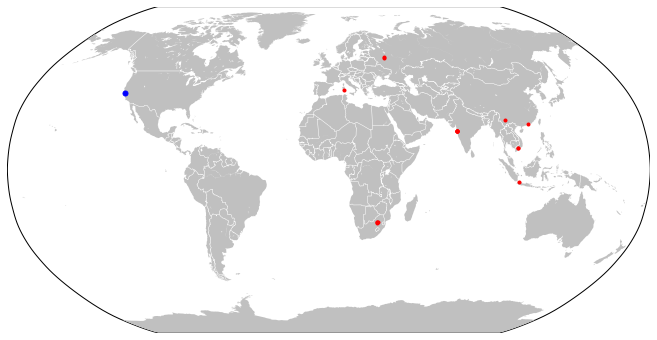

South America East
IP addresses: ['47.107.67.12', '223.100.110.66', '159.117.87.167', '202.83.122.170', '103.155.251.244', '58.8.84.129', '110.188.20.184', '103.123.108.197', '103.107.182.7', '123.30.234.76', '123.30.234.66', '123.195.161.145', '103.138.41.195', '151.192.142.124', '197.242.149.195', '103.199.19.132', '103.199.16.240', '103.136.18.163', '155.248.246.162', '47.106.85.147']


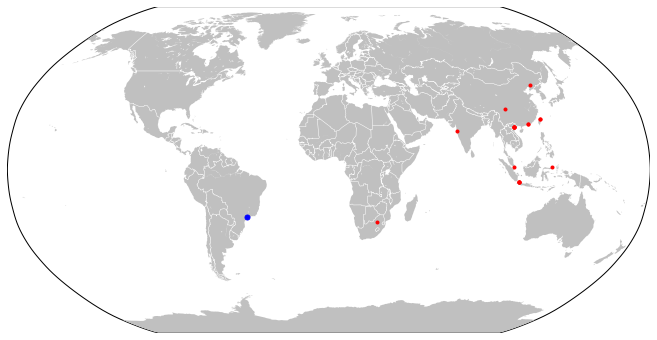

All
IP addresses: ['47.107.67.12', '80.211.91.157', '49.232.154.154', '103.136.18.163', '197.242.149.195', '154.0.173.6', '47.105.64.215', '41.21.230.0', '198.46.152.146', '58.8.84.129', '103.155.251.244', '102.37.108.139', '223.100.110.66', '141.168.36.153', '182.234.39.52', '151.192.142.124', '47.109.80.110', '116.62.230.170', '159.117.87.167', '121.133.94.94']


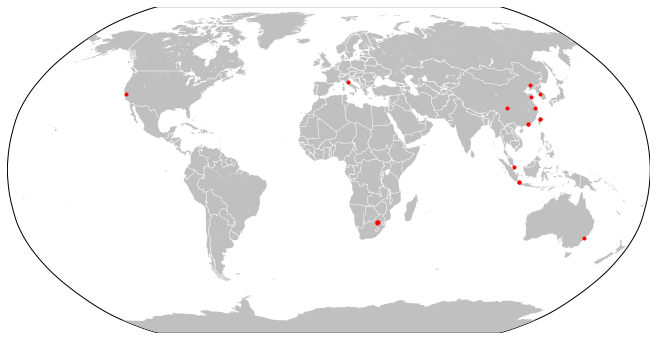

In [13]:
for key, vp in vantage_points.items():
    print(key)
    drawSlowestForProtocol("udp", key)

### Fastest UDP Resolvers

US East
IP addresses: ['132.145.167.127', '150.136.0.232', '34.86.106.186', '54.205.227.31', '150.136.110.156', '158.101.98.125', '140.82.63.113', '50.116.59.251', '144.126.151.188', '104.225.216.16', '192.3.60.181', '192.3.81.197', '107.173.52.46', '192.34.80.185', '192.3.73.139', '138.197.137.219', '172.105.16.134', '132.145.111.2', '94.140.14.14', '198.23.233.41']


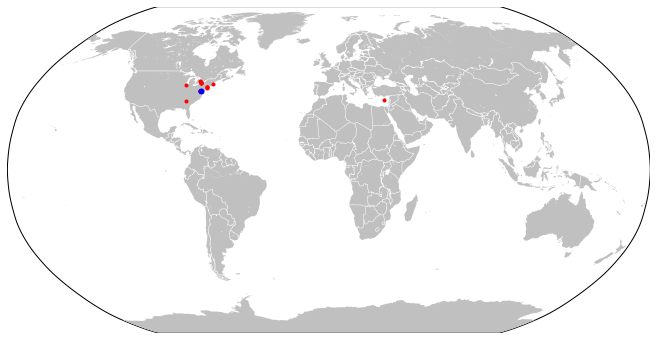

Asia Pacific Northeast
IP addresses: ['152.70.86.5', '152.69.204.173', '168.138.45.71', '168.138.53.111', '168.138.47.72', '168.138.36.228', '168.138.55.10', '218.251.80.123', '202.218.2.19', '206.190.236.73', '45.78.53.214', '192.243.125.8', '35.74.229.0', '41.216.180.37', '172.104.118.6', '172.104.107.146', '172.105.222.217', '160.251.96.67', '116.80.43.177', '158.101.67.106']


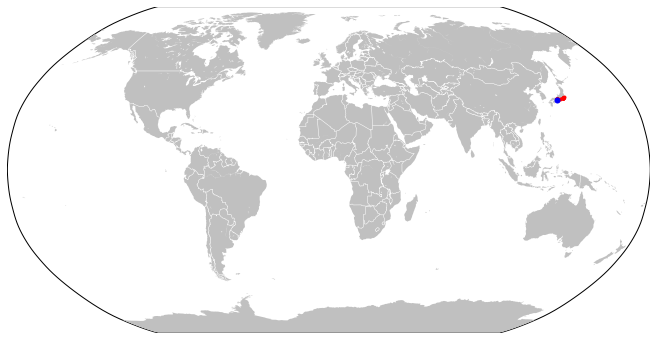

Africa South
IP addresses: ['102.37.108.139', '154.0.173.6', '41.21.230.0', '197.242.149.195', '51.195.149.247', '139.162.253.23', '3.9.78.39', '5.253.114.91', '140.238.86.206', '18.135.203.88', '178.128.163.23', '185.121.25.64', '45.155.39.173', '51.38.189.197', '37.187.19.215', '137.74.168.227', '87.98.165.2', '5.135.233.74', '176.31.83.186', '217.182.205.156']


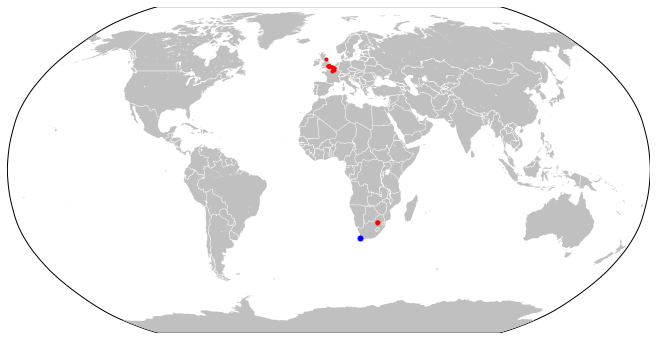

Europe Central
IP addresses: ['94.140.14.140', '94.140.14.141', '94.140.14.15', '94.140.14.14', '35.156.129.204', '94.140.15.15', '152.70.189.89', '130.61.15.226', '5.1.84.150', '94.140.15.16', '130.61.127.15', '62.113.206.254', '195.90.213.140', '130.61.69.193', '34.141.58.85', '20.52.130.183', '129.159.207.123', '130.61.75.201', '199.247.17.85', '188.68.59.46']


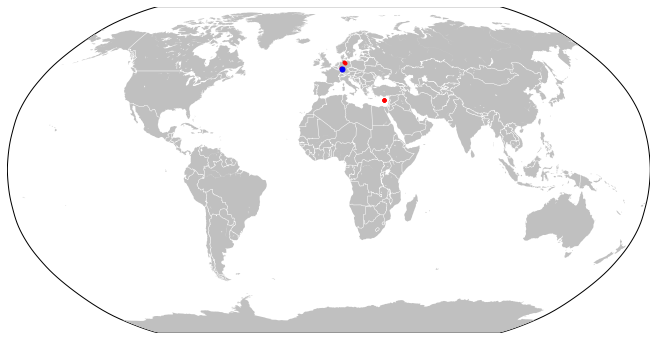

Asia Pacific Southeast
IP addresses: ['139.99.239.191', '112.213.39.133', '94.140.14.140', '94.140.14.141', '94.140.14.15', '94.140.14.14', '94.140.15.15', '94.140.15.16', '141.168.36.153', '40.65.190.185', '134.122.188.26', '134.122.129.221', '209.17.118.5', '139.99.90.8', '210.16.120.48', '178.128.84.245', '134.209.105.41', '68.183.235.0', '101.32.240.194', '157.245.202.244']


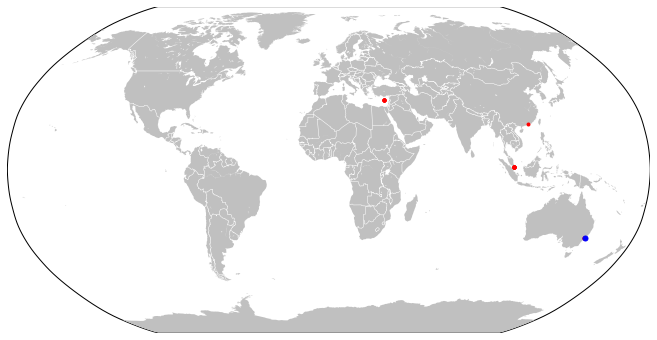

US West
IP addresses: ['47.254.64.251', '173.230.153.18', '143.110.230.80', '45.61.53.161', '94.140.14.140', '94.140.14.14', '94.140.15.15', '94.140.15.16', '199.115.228.98', '94.140.14.15', '185.238.248.204', '95.169.1.180', '202.5.18.122', '144.34.200.57', '198.211.40.216', '198.211.54.194', '64.64.239.154', '172.86.124.187', '110.34.192.81', '173.82.243.163']


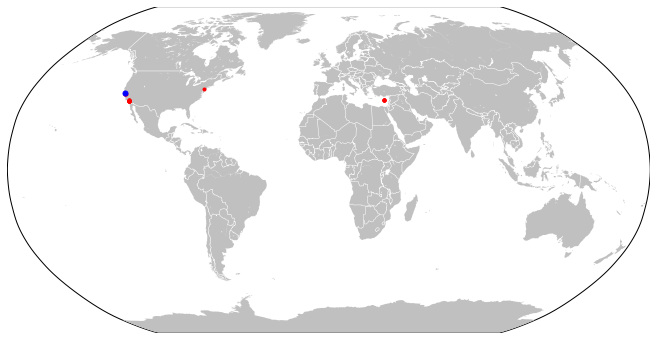

South America East
IP addresses: ['152.70.222.67', '50.116.59.251', '34.86.106.186', '54.205.227.31', '144.126.151.188', '140.82.63.113', '150.136.0.232', '150.136.110.156', '104.225.216.16', '132.145.167.127', '38.242.12.100', '158.101.98.125', '94.140.14.14', '94.140.14.140', '192.3.81.197', '94.140.15.16', '94.140.14.141', '94.140.15.15', '192.3.73.139', '107.173.52.46']


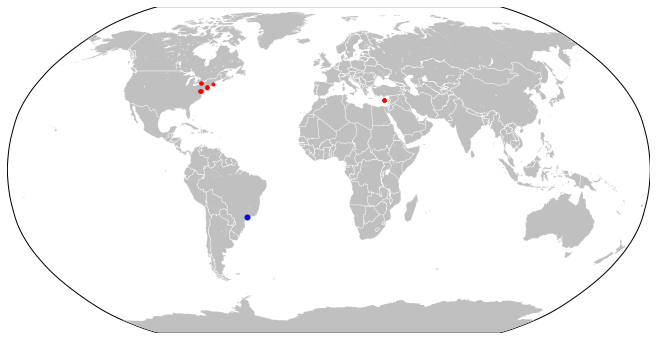

All
IP addresses: ['94.140.14.14', '94.140.14.140', '94.140.14.141', '94.140.14.15', '94.140.15.15', '94.140.15.16', '134.122.188.26', '134.122.129.221', '54.205.227.31', '150.136.0.232', '34.86.106.186', '132.145.167.127', '158.101.98.125', '104.225.216.16', '150.136.110.156', '130.211.204.156', '107.191.105.118', '34.121.75.184', '47.254.64.251', '129.146.170.128']


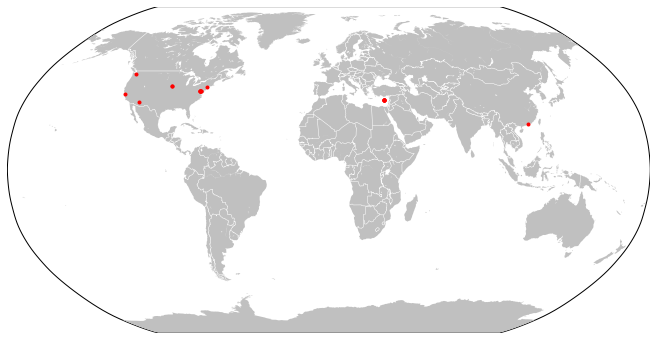

In [14]:
for key, vp in vantage_points.items():
    print(key)
    drawFastestForProtocol("udp", key)

## ASN

In [28]:
getASN()

,ASN,size,ASN Name
104,31898,48,ORACLE-BMC-31898
119,37963,46,CNNIC-ALIBABA-CN-NET-AP
79,20473,37,AS-CHOOPA
135,42473,34,AS-ANEXIA
142,45090,33,CNNIC-TENCENT-NET-AP
202,132203,28,TENCENT-NET-AP-CN
64,16276,27,OVH
57,14061,25,DIGITALOCEAN-ASN
116,36352,21,AS-COLOCROSSING
59,15169,20,GOOGLE


<br>
<br>
<br>
<br>

## UDP

In [34]:
print(getRCodeCountForProtocol("udp").to_markdown())

|   r_code |   count |
|---------:|--------:|
|        0 |   59632 |
|        2 |     363 |
|        3 |    1091 |
|        5 |    1885 |


In [35]:
print(getErrorSuccessCountForProtocol("udp").to_markdown())

| status     |      count |
|:-----------|-----------:|
| success    | 9366       |
| error      | 1493       |
| error_rate |    0.13749 |


#### All errors

In [36]:
print(getTotalErrorsCategorized("udp").to_markdown())

| error              |   count |
|:-------------------|--------:|
| connection_refused |   16907 |
| timeout            |  111958 |
| no_route           |     536 |
| overflow           |      17 |


#### Errors for Successful Servers

In [37]:
print(getErrorsCategorized("udp").to_markdown())

| error              |   count |
|:-------------------|--------:|
| connection_refused |     222 |
| timeout            |    1263 |
| no_route           |       3 |
| overflow           |       5 |


<br>
<br>
<br>
<br>

## TCP

In [62]:
print(getRCodeCountForProtocol("tcp").to_markdown())

|   r_code |   count |
|---------:|--------:|
|        0 |   59919 |
|        2 |     343 |
|        3 |    1101 |
|        5 |    3037 |


In [63]:
print(getErrorSuccessCountForProtocol("tcp").to_markdown())

| status     |       count |
|:-----------|------------:|
| success    | 9366        |
| error      | 1566        |
| error_rate |    0.143249 |


#### All errors

In [71]:
print(getTotalErrorsCategorized("tcp").to_markdown())

| error               |   count |
|:--------------------|--------:|
| connection_refused  |   19881 |
| timeout             |  106546 |
| eof                 |     510 |
| no_route            |     784 |
| network_unreachable |       2 |
| connection_reset    |       2 |


#### Errors for Successful Servers

In [64]:
print(getErrorsCategorized("tcp").to_markdown())

| error              |   count |
|:-------------------|--------:|
| connection_refused |     253 |
| timeout            |    1305 |
| no_route           |       8 |


#### TCP Fast Open (TFO)

No servers were found with support for TFO

#### edns-tcp-keepalive

12 resolvers were found to support edns-tcp-keepalive. They are all part of the AdGuard Organization. The timeout value returned for all of them is 0 meaning to close the connection after having received the response.

<br>
<br>
<br>
<br>

## TLS

In [42]:
print(getRCodeCountForProtocol("tls").to_markdown())

|   r_code |   count |
|---------:|--------:|
|        0 |  118487 |
|        2 |     393 |
|        3 |    1571 |
|        5 |    1241 |


In [91]:
print(getErrorSuccessCountForProtocol("tls").to_markdown())

| status     |        count |
|:-----------|-------------:|
| success    | 17224        |
| error      |  2357        |
| error_rate |     0.120372 |


#### All errors

In [97]:
print(getTotalErrorsCategorized("tls").to_markdown())

| error              |   count |
|:-------------------|--------:|
| connection_refused |   12137 |
| timeout            |   56516 |
| unrecognized_name  |     222 |
| no_route           |     987 |
| tls_internal_error |     253 |
| eof                |      16 |
| connection_reset   |       2 |


#### Errors for Successful Servers

In [92]:
print(getErrorsCategorized("tls").to_markdown())

| error              |   count |
|:-------------------|--------:|
| connection_refused |     149 |
| timeout            |    2198 |
| no_route           |      10 |


#### TLS Versions

In [46]:
print(getTLSVersions("tls").to_markdown())

|   tls_version |   count |
|--------------:|--------:|
|           772 |  121692 |


In [4]:
certs = pd.read_csv("certs.csv", converters={"info":json.loads}, header = None, names = ["ip", "protocol", "port", "info"])
certs["version"] = certs.apply(lambda row: row["info"]["Version"], axis = 1)
certs["public_key_algorithm"] = certs.apply(lambda row: row["info"]["PublicKeyAlgorithm"], axis = 1)
certs["signature_key_algorithm"] = certs.apply(lambda row: row["info"]["SignatureAlgorithm"], axis = 1)
certs["size"] = certs.apply(lambda row: row["info"]["Size"], axis = 1)

In [116]:
certs_tls = certs[certs["protocol"] == "tls"]

In [122]:
certs_tls.groupby("version").size().reset_index(name = "count")

,version,count
0,1,1
1,3,699


In [120]:
certs_tls.groupby("public_key_algorithm").size().reset_index(name = "count")

,public_key_algorithm,count
0,ECDSA,234
1,RSA,466


In [121]:
certs_tls.groupby("signature_key_algorithm").size().reset_index(name = "count")

,signature_key_algorithm,count
0,ECDSA-SHA256,10
1,ECDSA-SHA384,22
2,SHA1-RSA,3
3,SHA256-RSA,655
4,SHA384-RSA,9
5,SHA512-RSA,1


In [9]:
def build(df, dictKey = "signature_key_algorithm"):
    result = {}
    for key in df[dictKey].unique():
        result[key] = df[df[dictKey] == key]["size"].tolist()
    return pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in result.items() ]))

In [18]:
ax = build(certs_tls, "public_key_algorithm").plot.hist(bins = 100, figsize = (10, 7), alpha = 0.7)
plt.grid()
ax.set_xlabel("bytes")
plt.savefig("figures/tls_cert_sizes.pdf", bbox_inches='tight')

NameError: name 'certs_tls' is not defined

## QUIC

In [5]:
certs_quic = certs[certs["protocol"] == "quic"]

In [17]:
certs_quic.groupby("version").size().reset_index(name = "count")

,version,count
0,1,2
1,3,760


In [11]:
pub_key = certs_quic.groupby("public_key_algorithm").size().reset_index(name = "count")
pub_key["percentage"] = pub_key["count"] / pub_key["count"].sum()
pub_key

,public_key_algorithm,count,percentage
0,ECDSA,252,0.330709
1,RSA,510,0.669291


In [16]:
sign_key = certs_quic.groupby("signature_key_algorithm").size().reset_index(name = "count")
sign_key["percentage"] = sign_key["count"] / sign_key["count"].sum()
sign_key.sort_values("count", ascending = False)

,signature_key_algorithm,count,percentage
3,SHA256-RSA,701,0.919948
1,ECDSA-SHA384,34,0.044619
0,ECDSA-SHA256,12,0.015748
4,SHA384-RSA,11,0.014436
2,SHA1-RSA,3,0.003937
5,SHA512-RSA,1,0.001312


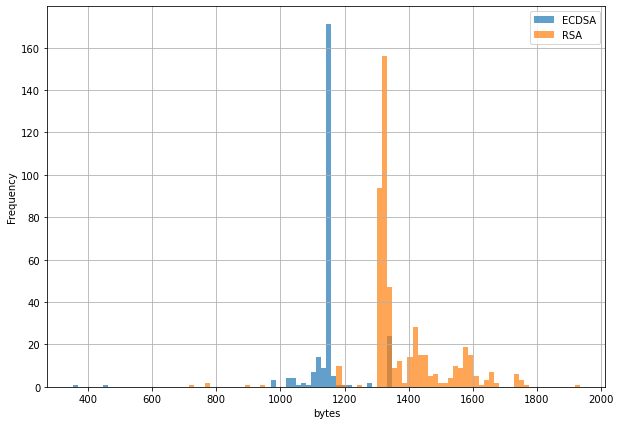

In [20]:
ax = build(certs_quic, "public_key_algorithm").plot.hist(bins = 100, figsize = (10, 7), alpha = 0.7)
plt.grid()
ax.set_xlabel("bytes")
plt.savefig("figures/quic_cert_sizes.pdf", bbox_inches='tight')

<br>
<br>
<br>
<br>

## HTTPS

In [47]:
print(getRCodeCountForProtocol("https").to_markdown())

|   r_code |   count |
|---------:|--------:|
|        0 |   79788 |
|        2 |     334 |
|        3 |    1555 |
|        5 |     710 |


In [175]:
print(getErrorSuccessCountForProtocol("https").to_markdown())

| status     |         count |
|:-----------|--------------:|
| success    | 11328         |
| error      |   826         |
| error_rate |     0.0679612 |


#### All errors

In [49]:
print(getTotalErrorsCategorized("https").to_markdown())

| error                 |   count |
|:----------------------|--------:|
| connection_refused    |   17353 |
| request_canceled      |   26320 |
| timeout               |    4578 |
| overflow              |   14492 |
| eof                   |    1637 |
| tls_internal_error    |    3633 |
| stream_error          |    2211 |
| bad_rdata             |    3189 |
| too_many_redirect     |     224 |
| connection_reset      |     212 |
| tls_handshake_failure |     878 |
| http_response         |     915 |
| no_route              |     393 |
| unrecognized_name     |     442 |


#### Errors for Successful Servers

In [176]:
print(getErrorsCategorized("https").to_markdown())

| error              |   count |
|:-------------------|--------:|
| overflow           |     274 |
| request_canceled   |     320 |
| tls_internal_error |      23 |
| connection_refused |     121 |
| timeout            |      56 |
| no_route           |       4 |


#### TLS Versions

In [51]:
print(getTLSVersions("https").to_markdown())

|   tls_version |   count |
|--------------:|--------:|
|           771 |     967 |
|           772 |   81420 |


#### HTTP Version

In [52]:
print(getHTTPVersion().to_markdown())

| http_version   |   count |
|:---------------|--------:|
| HTTP/1.1       |    1239 |
| HTTP/2.0       |   81148 |


In [135]:
certs_https = certs[certs["protocol"] == "https"]

In [136]:
certs_https.groupby("version").size().reset_index(name = "count")

,version,count
0,1,2
1,3,648


In [137]:
certs_https.groupby("public_key_algorithm").size().reset_index(name = "count")

,public_key_algorithm,count
0,ECDSA,231
1,RSA,419


In [138]:
certs_https.groupby("signature_key_algorithm").size().reset_index(name = "count")

,signature_key_algorithm,count
0,ECDSA-SHA256,13
1,ECDSA-SHA384,23
2,SHA1-RSA,2
3,SHA256-RSA,600
4,SHA384-RSA,11
5,SHA512-RSA,1


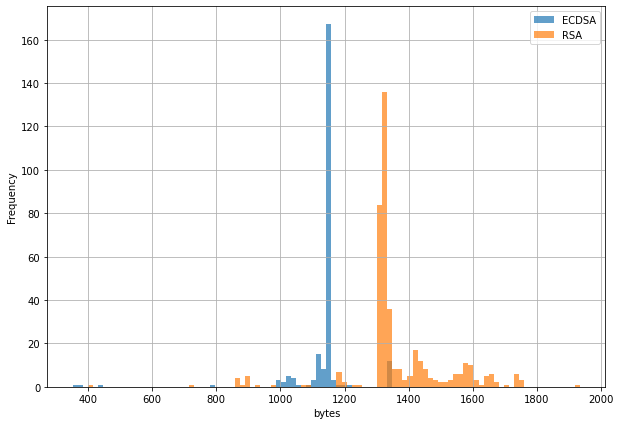

In [177]:
ax = build(certs_https, "public_key_algorithm").plot.hist(bins = 100, figsize = (10, 7), alpha = 0.7)
plt.grid()
ax.set_xlabel("bytes")
plt.savefig("figures/https_cert_sizes.pdf", bbox_inches='tight')

<br>
<br>
<br>
<br>

## Maps

#### Slowest UDP Resolvers

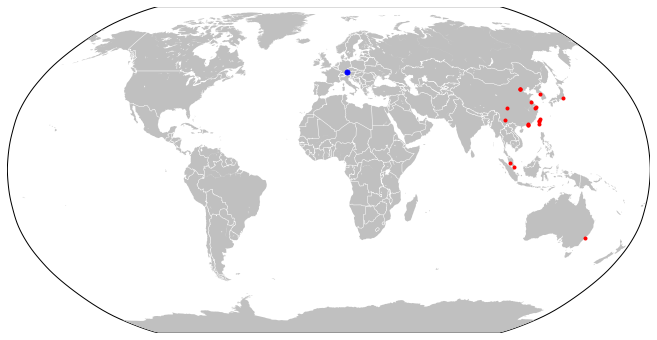

In [81]:
drawSlowestForProtocol("udp")

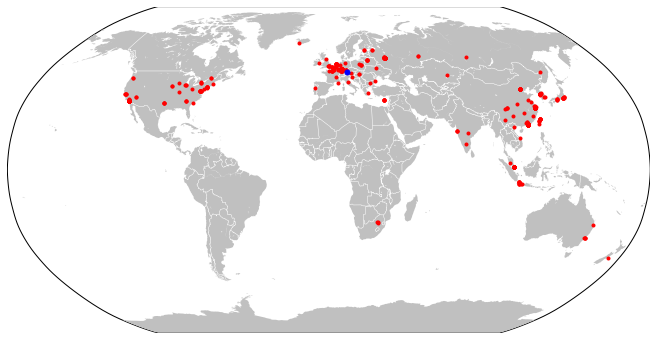

In [82]:
drawAllForProtocol("udp")

#### Slowest TCP Resolvers

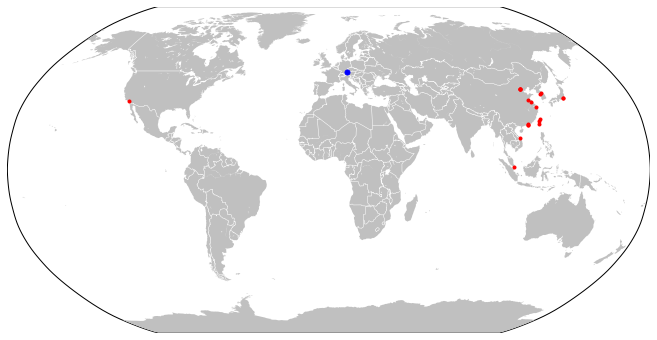

In [83]:
drawSlowestForProtocol("tcp")

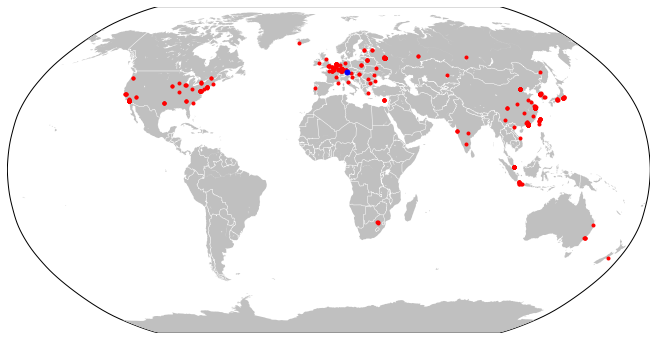

In [84]:
drawAllForProtocol("tcp")

#### Slowest TLS Resolvers

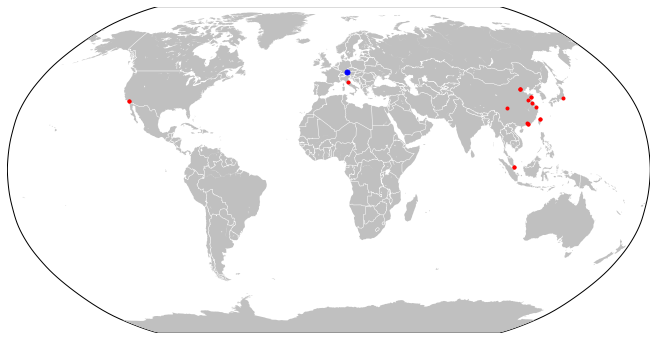

In [85]:
drawSlowestForProtocol("tls")

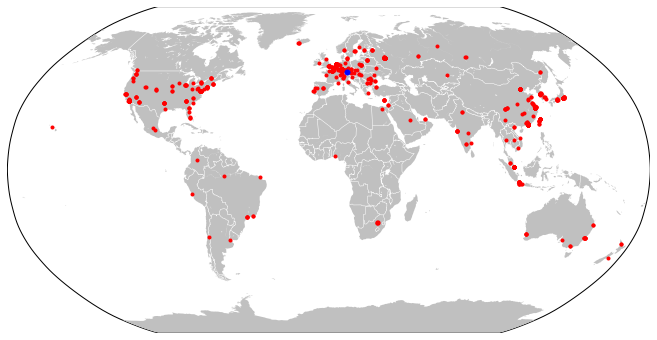

In [86]:
drawAllForProtocol("tls")

#### Slowest HTTPS Resolvers

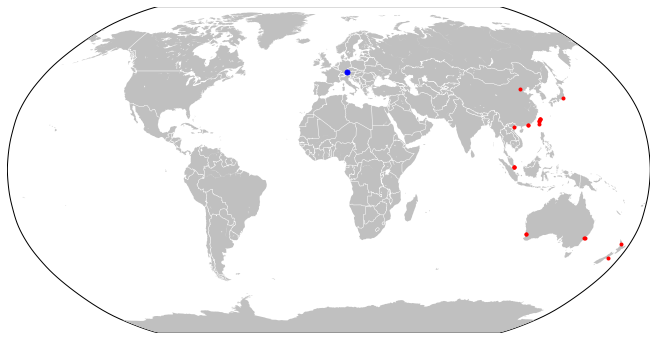

In [87]:
drawSlowestForProtocol("https")

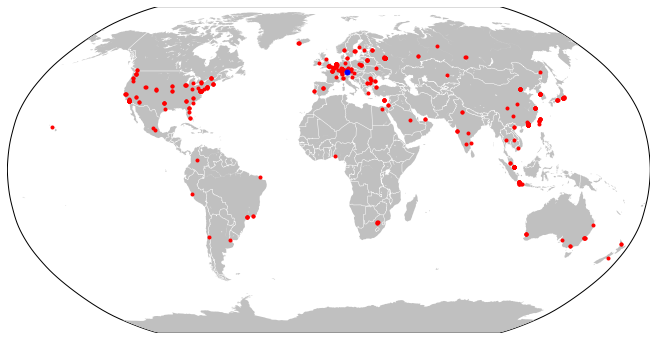

In [88]:
drawAllForProtocol("https")

<br>
<br>
<br>
<br>